## Introduction / Business Problem

#### Or, The Most Appropriate Present Ever
----------------------------------------

A few years ago, my wife got me a present for my birthday that was, pretty much, the best present I have ever received. It wasn't an expensive or fancy present; it was a simple t-shirt, and probably cost less than a couple packs of underwear or socks (as we all know, the most boring presents imaginable). It wasn't even that it was a particularly great shirt with an amazing design, or anything like that; in fact, it's one of the plainest t-shirts that I own, just a solid maroon with simple white lettering on the front of it. But it's what it _says_ that's most important, a statement that perfectly aligns with my interests and personality:

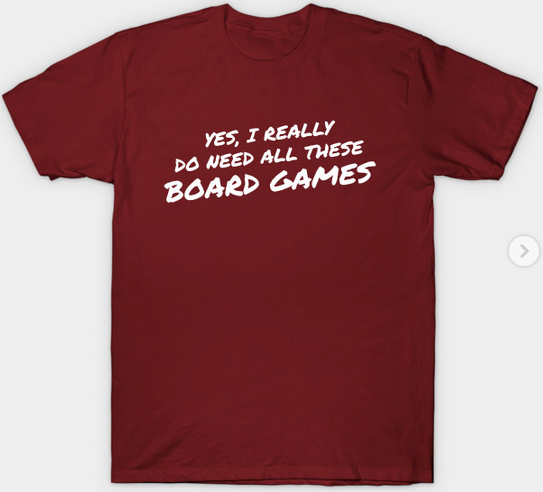

Truly, board games are one of my great passions, and my collection continues to grow (even if it is, admittedly, getting a _touch_ out of control). And one of the things that has always been in the back of my mind is opening a board game store or cafe, to help share my passion with the world.

Somewhat unfortunately, though, I happen to live in a town that already has a game store in it, and naturally, I know of a bunch of other local game stores as well. So if I ever did want to open a game store of my own that wouldn't step on the toes of an existing business, I'd need to make sure that I wasn't opening one in an area that already had one, and I honestly had no real idea of how to figure out the answer to that question - until now!

Put formally, the business problem here is figuring out a location where a board game store/cafe could be opened that isn't in an area that already has a large number of board game stores and/or cafes. While the problem solved in this particular application is appropriate to just me, the methodology used in this project could be adapted to any number of venue types and geographical areas anywhere in the world.

The particular idea that I have is that of a board game cafe - i.e. a place that has a collection of board games available for sale & rent, where people can come to play, that will also have refreshments available for purchase: drinks, snacks, baked goods, etc. I would like to find the best location around my hometown of Chelmsford, MA for this new business.

In order to find the best place for a new business of this type, I need to "thread the needle" of making sure that a location fulfills the following criteria:
1. Not too close to an existing business of the same type (to avoid flooding the market in a specific area)
2. Not too far away from other businesses of other types (to avoid picking a location that is too remote to make any money)

## Data
---

The data needed for this project is relatively simple. All that's needed for geospatial density-based clustering of business types is the name of the business, its latitude/longitude, and the business type, which can easily be queried from Foursquare and stored in a dataframe like this:

| Venue | Venue Latitude | Venue Longitude | Venue Category |
| ----- | -------------- | --------------- | -------------- |
| Three Trolls Games | 42.594031 | -71.348419 | Toy / Game Store |

### Data Collection
---

The Foursquare API has a limitation in that each query will only return about 100 results. So, in order to get enough data to make the clustering effective, I need to do two things:

1. Limit our queries to relevant business types
2. Perform multiple queries around Chelmsford

First, I need to limit my queries to relevant business types. Since I am looking to start a new board game cafe, which is a combination of a brick & mortar store, entertainment venue, and food service venue, I need to limit my more general query to those that I would expect to compete with and/or complement that kind of business. Taking a peek through the [Foursquare category list](https://developer.foursquare.com/docs/build-with-foursquare/categories/), I think I can concentrate on the following categories:
- Bakery
- Coffee Shop
- Comic Shop
- Gaming Cafe
- Hobby Shop
- Toy / Game Store

After performing the query centered on Chelmsford itself, I'll take a "delta" parameter and add/subtract it from the Chelmsford latitude & longitude values in turn, thus performing queries in a circular-shaped pattern around the original central value. By doing multiple loops and increasing the delta each time, I'll be performing queries in a spiraling pattern to increase my coverage of the local area.

In [1]:
# The code was removed by Watson Studio for sharing.

## Methodology
---

The methodology for this problem will consist of two main steps after getting venue data for all businesses in a 50-mile radius around Chelmsford, MA. In both steps, the DBSCAN clustering technique, which specializes in finding irregularly-shaped clusters based on density of points, will be used to determine the following:
1. The areas of lowest concentration of board game-specific stores (found by first filtering the Foursquare data to just those business types and then running DBSCAN)
2. The areas of highest concentration of businesses of other relevant types

After the above steps are completed, I should be able to visualize the two DBSCAN cluster maps and compare them to find the most likely places that would support a new board game cafe.

In [2]:
# Import required packages
import requests
import pandas as pd
import numpy as np
from geopy.geocoders import Nominatim
import pprint
import copy

# Define constant value with client ID, secret, and version information
FS_AUTH = f'client_id={CLIENT_ID}&client_secret={CLIENT_SECRET}&v={VERSION}'

In [3]:
# Query Foursquare API to get the venue category IDs needed to filter the search queries
url = f'https://api.foursquare.com/v2/venues/categories?&{FS_AUTH}'
categories_json = requests.get(url).json()["response"]["categories"]

category_id_dict = {}

for category in ["Bakery", "Coffee Shop", "Comic Shop", "Gaming Cafe", "Hobby Shop", "Toy / Game Store"]:
    for top_level_category in categories_json:
        for subcategory in top_level_category["categories"]:
            if category == subcategory["name"]:
                category_id_dict[category] = subcategory["id"]

In [4]:
address = 'Chelmsford, MA'

geolocator = Nominatim(user_agent="bpr_explorer")
location = geolocator.geocode(address)
cford_lat = location.latitude
cford_lng = location.longitude
print('The geographical coordinates of Chelmsford are {}, {}.'.format(cford_lat, cford_lng))

The geographical coordinates of Chelmsford are 42.5998139, -71.3672838.


Now that I have the base coordinates of Chelmsford and the category types I want to search, I'll do a series of queries that search the area in and around Chelmsford to build the list of businesses.

In addition to the full list of all businesses returned by Foursquare, I will save just the toy/game stores and gaming cafes in a separate dataframe for the more specific clustering case, as well as a third dataframe containing just the gaming cafes for visualization purposes.

In [5]:
radius = 8000

venues_list = []

for i in range(0, 4):
    
    delta = .1 * i
    
    lats_and_lngs = [(cford_lat+delta, cford_lng), 
                     (cford_lat+delta, cford_lng+delta), 
                     (cford_lat, cford_lng+delta), 
                     (cford_lat-delta, cford_lng+delta),
                     (cford_lat-delta, cford_lng), 
                     (cford_lat-delta, cford_lng-delta), 
                     (cford_lat, cford_lng-delta)]
    
    for latlong_tuple in lats_and_lngs:
        
        for search_cat, search_id in category_id_dict.items():

            # create the API request URL
            url = f'https://api.foursquare.com/v2/venues/search?&{FS_AUTH}&categoryId={search_id}&ll={latlong_tuple[0]},{latlong_tuple[1]}&radius={radius}&limit={LIMIT}'
            
            # make the GET request
            results = requests.get(url).json()["response"]["venues"]
  
            for v in results:
                # return only relevant information for each nearby venue
                name = v.get("name")
                lat = v.get("location", {}).get("lat")
                lng = v.get("location", {}).get("lng")
                if len(v.get("categories")) > 0:
                    category = v.get("categories")[0].get('name')
                else:
                    continue
                venues_list.append([name, lat, lng, category])

cford_venues = pd.DataFrame(venues_list)

cford_venues.columns = ['Venue', 
                        'Venue Latitude', 
                        'Venue Longitude', 
                        'Venue Category']

cford_venues.drop_duplicates(inplace=True)

gaming_venues = copy.deepcopy(cford_venues.loc[cford_venues["Venue Category"].isin(["Gaming Cafe", "Toy / Game Store"])])

gaming_cafe_venues = copy.deepcopy(cford_venues.loc[cford_venues["Venue Category"].isin(["Gaming Cafe"])])

I'll check the top of the first two dataframes now, to ensure the data looks good.

In [6]:
cford_venues.head()

Venue  Venue Latitude  Venue Longitude  \
0                 Sugar Bake Shoppe       42.597504       -71.351204   
1                      Panera Bread       42.566839       -71.425048   
2                      Panera Bread       42.622488       -71.361989   
3                    Olympos Bakery       42.644104       -71.318536   
4  Lowell Asian Restaurant & Bakery       42.644030       -71.321338   

       Venue Category  
0              Bakery  
1              Bakery  
2              Bakery  
3              Bakery  
4  Chinese Restaurant

I can see from the inclusion of a Chinese restaurant in the overall list of venues that the Foursquare filtering on category ID is not super-strict, which is actually good for my purposes since that means that a few other business types have slipped in, making it more likely that the DBSCAN clustering will give me a good picture of where businesses are located.

In [7]:
gaming_venues.head()

Venue  Venue Latitude  Venue Longitude  \
79                P K Smooths       42.640780       -71.297469   
80  Masters Gaming Connection       42.643368       -71.334373   
81          The Royal Wetbert       42.563970       -71.271945   
89         Three Trolls Games       42.594031       -71.348419   
90             Larry's Comics       42.649608       -71.305473   

      Venue Category  
79       Gaming Cafe  
80       Gaming Cafe  
81       Gaming Cafe  
89  Toy / Game Store  
90  Toy / Game Store

### Clustering
---

Here, I will cluster the venues in each of the above dataframes using the DBSCAN algorithm. Due to the fact that the venues in the gaming dataset are much sparser than those in the overall venue dataset, the _epsilon_ and _min_samples_ parameters need to be adjusted between the clustering attempts - specifically, both parameters need to be increased to allow for more leeway in the creation of clusters.

In [8]:
from sklearn.cluster import DBSCAN
import sklearn.utils
from sklearn.preprocessing import StandardScaler
sklearn.utils.check_random_state(1000)
Clus_dataSet = cford_venues[['Venue Latitude','Venue Longitude']]
Clus_dataSet = StandardScaler().fit_transform(Clus_dataSet)

# Compute DBSCAN for the full set of venues
db = DBSCAN(eps=0.2, min_samples=5).fit(Clus_dataSet)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
cford_labels = db.labels_
cford_venues["clusterLabel"]=cford_labels

gaming_dataSet = gaming_venues[['Venue Latitude','Venue Longitude']]
gaming_dataSet = StandardScaler().fit_transform(gaming_dataSet)

# Compute DBSCAN
gaming_db = DBSCAN(eps=0.35, min_samples=3).fit(gaming_dataSet)
core_samples_mask = np.zeros_like(gaming_db.labels_, dtype=bool)
core_samples_mask[gaming_db.core_sample_indices_] = True
gaming_labels = gaming_db.labels_
gaming_venues["clusterLabel"]=gaming_labels

## Results, Visualization, and Discussion
---

Now that the clustering has been completed, I will plot the results on a series of maps and make the necessary observations. The first step is to get an idea of what the overall dataset looks like by plotting all businesses on a map of the area surrounding Chelmsford, MA.

In [9]:
# @hidden-cell
!conda install -c conda-forge folium

Solving environment: done

# All requested packages already installed.



In [10]:
import folium
from folium import Popup
from folium.features import DivIcon
import matplotlib.cm as cm
import matplotlib.colors as colors
from IPython.display import display

In [11]:
cford_map = folium.Map(location=[cford_lat, cford_lng], zoom_start=10)

for lat, lng, name in zip(cford_venues["Venue Latitude"], cford_venues["Venue Longitude"], cford_venues["Venue"]):
    folium.CircleMarker([lat, lng], popup=Popup(name, parse_html=True), radius=5, color="blue", fill=True, fill_color="blue", opacity=0.25).add_to(cford_map)
    
display(cford_map)

In order to ensure that I know exactly where the existing gaming cafes are, I'll display a map with just those, for future reference.

In [12]:
gaming_cafe_map = folium.Map(location=[cford_lat, cford_lng], zoom_start=10)

for lat, lng, name in zip(gaming_cafe_venues["Venue Latitude"], gaming_cafe_venues["Venue Longitude"], gaming_cafe_venues["Venue"]):
    folium.Marker([lat, lng], popup=Popup(name, parse_html=True)).add_to(gaming_cafe_map)
    
display(gaming_cafe_map)

Next is a visualization of the DBSCAN clustering of the overall set of businesses:

In [13]:
# Set color scheme for the clusters
x = np.arange(cford_labels.max())
ys = [i + x + (i*x)**2 for i in range(cford_labels.max())]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

cford_map_clusters = folium.Map(location=[cford_lat, cford_lng], zoom_start=10)

for lat, lng, name, cluster in zip(cford_venues["Venue Latitude"], cford_venues["Venue Longitude"], cford_venues["Venue"], cford_venues["clusterLabel"]):
    folium.CircleMarker([lat, lng], radius=5, popup=Popup(name, parse_html=True), color=rainbow[cluster-1], fill=True, fill_color=rainbow[cluster-1], fill_opacity=0.7).add_to(cford_map_clusters)
    
display(cford_map_clusters)

This map is pretty much exactly what I expected to see when clustering all types of businesses. The main cluster in red encompasses Boston and the immediate surrounding suburbs, but because of the way that DBSCAN calculates its neighbors, you can see that it expands and follows all the major highways out to all the nearby major cities:
- Interstate 93, which expands south to Quincy and all the way north into Manchester, N.H.
- The Massachusetts Turnpike, which goes west to Framingham
- Interstate 95 / Route 128, which curves around Boston and hits cities such as Waltham and Burlington
- Route 3, which goes northwest from 95 and passes by Lowell and Nashua, N.H.
- Route 495, which parallels 95 with a wider radius, and goes through Andover, Lowell, Westford, and Littleton

And I can also see from looking at the smaller clusters that they also are centered around highways, like:
- The purple cluster around Route 2 in Concord and Acton
- The orange cluster going up Route 1
- The green cluster in the west, which encompasses Rt 20 in Marlborough, Rt 9 in Westborough and Shrewsbury, and some shopping off of I-290 heading towards Worcester

So the takeaway here is that if you are looking to start a new business in northeastern Mass. or southern N.H., it needs to be near or on a major road.

So now, let's view the gaming/toy business clusters and see what that map tells us.

In [14]:
# Set color scheme for the clusters
x = np.arange(gaming_labels.max())
ys = [i + x + (i*x)**2 for i in range(gaming_labels.max())]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

gaming_map_clusters = folium.Map(location=[cford_lat, cford_lng], zoom_start=10)

for lat, lng, name, cluster in zip(gaming_venues["Venue Latitude"], gaming_venues["Venue Longitude"], gaming_venues["Venue"], gaming_venues["clusterLabel"]):
    folium.CircleMarker([lat, lng], radius=5, popup=Popup(name, parse_html=True), color=rainbow[cluster-1], fill=True, fill_color=rainbow[cluster-1], fill_opacity=0.7).add_to(gaming_map_clusters)
    
display(gaming_map_clusters)

It's quickly apparent where the biggest clusters of gaming & toy stores are:
- Boston & surrounding suburbs (inside I-95)
- Framingham
- Lowell

And there are some smaller, yet still defined clusters:
- Acton/Maynard
- Nashua, N.H.
- Salem, N.H.
- Manchester, N.H.

But before I make my final conclusions, I'm going to make one more map, and add back in the points for the other businesses and the markers of the gaming cafes so that I can get the fullest picture possible.

In [15]:
cford_venues_nogaming = copy.deepcopy(cford_venues)
cford_venues_nogaming.drop(cford_venues_nogaming.loc[cford_venues["Venue Category"].isin(["Gaming Cafe", "Toy / Game Store"])].index, inplace=True)

In [16]:
full_map_with_clusters = folium.Map(location=[cford_lat, cford_lng], zoom_start=10)

for lat, lng, name, cluster in zip(gaming_venues["Venue Latitude"], gaming_venues["Venue Longitude"], gaming_venues["Venue"], gaming_venues["clusterLabel"]):
    folium.CircleMarker([lat, lng], popup=Popup(name, parse_html=True), radius=5, color=rainbow[cluster-1], fill=True, fill_color=rainbow[cluster-1], fill_opacity=0.7).add_to(full_map_with_clusters)
    
for lat, lng, name in zip(cford_venues_nogaming["Venue Latitude"], cford_venues_nogaming["Venue Longitude"], cford_venues_nogaming["Venue"]):
    folium.CircleMarker([lat, lng], radius=1, color="black", fill=True, fill_color="black", opacity=0.7).add_to(full_map_with_clusters)
    
for lat, lng, name in zip(gaming_cafe_venues["Venue Latitude"], gaming_cafe_venues["Venue Longitude"], gaming_cafe_venues["Venue"]):
    folium.Marker([lat, lng], popup=Popup(name, parse_html=True)).add_to(full_map_with_clusters)
    
display(full_map_with_clusters)

## Recommendations
---

After examining the overall map, I can identify my top 3 locations where a board game cafe might work out without running into too much local competition.
1. **Intersection of I-495 and Rt 20 in Marlborough:** This location has a tight grouping of businesses, but very few game/toy stores and no existing cafes. Being right next to two major thoroughfares and away from other competing businesses gives me a great chance for success.
2. **Burlington, MA:** The Burlington Mall is a massive shopping center and there are many businesses in the surrounding areas, but no existing board game cafes. While that might be attributable to possibly high rent inside the mall itself, I'd be willing to bet that a smaller location in the surrounding town would have a great chance of capturing some of the existing traffic.
3. **Methuen, MA:** With plenty of businesses and a confluence of multiple highways, Methuen is far enough away from the existing board game cafes that a new one would likely be viable.

One final map, with the recommendation sites clearly marked:

In [17]:
i = 1
for address in ['Bear Hill, Marlborough, MA', 'Simonds Park, Burlington, MA', 'Methuen, MA']:
    geolocator = Nominatim(user_agent="bpr_explorer")
    location = geolocator.geocode(address)
    lat = location.latitude
    lng = location.longitude
    folium.Marker([lat, lng], icon=DivIcon(icon_size=(250,36), icon_anchor=(15, 50), html=f'<div style="font-size: 40pt; color: black">{i}</div>')).add_to(gaming_map_clusters)
    i += 1
    
display(gaming_map_clusters)

## Conclusion
---

DBSCAN is an excellent tool for geospatial applications and was very useful in helping me to identify the optimal locations for a new business. While deciding whether or not to actually open a business in a specific location is a much more involved undertaking, I feel that the methodology used in this analysis will save potential entrepreneurs valuable time in narrowing down an initial list of possible locations.